In [1]:
from pathlib import Path
from PIL import Image
import pandas as pd
import json
import os
from collections import namedtuple
import matplotlib.pyplot as plt


# Libraries used by OG TA here: https://colab.research.google.com/drive/1tDiyVcWrBi7pew7uUX3HEwkl5G5h0jmp?usp=sharing#scrollTo=VW64heyUiHFn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image
import torchvision.transforms as T

# Summary Stats

In [2]:
# Getting the Path where the x-ray images are stored
current_dir = Path.cwd()

# Get the parent directory of the current file
parent_dir = current_dir.parent

# Join the parent directory with the name of the adjacent folder
data_path = parent_dir.joinpath('/chest_xray')

# Ruben Notes
# Gave up on the logic above so I created a variable with the directory
current_directory = '/Users/rubengallardo/Documents/GitHub/Spring_2024/ml_project/chest_xray'

os.listdir(current_directory)

['.DS_Store', 'test', 'chest_xray', '__MACOSX', 'train', 'val']

In [3]:
Image_Stats =  namedtuple('Image_Stats', ["split", "label", "width", "height", "pixels_sq", "ratio"])

METRICS = ["widths", "heights", "pixels_sq", "ratios"]
def compile_stats(data_path):
    tup_list = []
    sum_stats = {}
    for folder_l1 in os.listdir(data_path):     
        #iterating through test, train, and val
        if folder_l1 in ('.DS_Store', '__MACOSX'):
            continue
        fl1 = os.path.join(data_path, folder_l1)
        
        # checking if it is a folder
        if not os.path.isdir(fl1):
            continue
        sum_stats[folder_l1] = {}
        for folder_l2 in os.listdir(fl1):
            #iterating through Normal and Pnemonia
            if folder_l2 == '.DS_Store':
                continue
            fl2 = os.path.join(fl1, folder_l2)
            if not os.path.isdir(fl2):
                continue
            sum_stats[folder_l1][folder_l2] = {}

            for filename in os.listdir(fl2):
                #iterating through images
                if filename == '.DS_Store':
                    continue
                f = os.path.join(fl2, filename)
                # checking if it is a file
                if not os.path.isfile(f):
                    continue
                
                
                image_obj = Image.open(f)

                #initializing empty lists of summary statistics
                for m in METRICS:
                    sum_stats[folder_l1][folder_l2][m] = sum_stats[folder_l1][folder_l2].get(m, [])

                #fillin in the summary statistics
                sum_stats[folder_l1][folder_l2]["widths"].append(image_obj.width)
                sum_stats[folder_l1][folder_l2]["heights"].append(image_obj.height)
                
                #calculating square pixels
                square_pixels = int(image_obj.height) * int(image_obj.width)
                sum_stats[folder_l1][folder_l2]["pixels_sq"].append(square_pixels)
                ratio = int(image_obj.width)/int(image_obj.height)
                sum_stats[folder_l1][folder_l2]["ratios"].append(ratio)
                
                # Converted labels to boolean attribute
                if  folder_l2 == 'PNEUMONIA':
                    img_label = 1
                else: 
                    img_label = 0
                
                tup =  Image_Stats(folder_l1, img_label, image_obj.width, image_obj.height, square_pixels, ratio)
                tup_list.append(tup)

                del image_obj

    return sum_stats, tup_list

In [4]:
dic, tup_list = compile_stats(current_directory)
df = pd.DataFrame(tup_list)
df["ratio"].mean()

# Check a few rows of the data frame
df.head(100)

,split,label,width,height,pixels_sq,ratio
0,test,1,1120,808,904960,1.386139
1,test,1,1040,696,723840,1.494253
2,test,1,1016,544,552704,1.867647
3,test,1,976,608,593408,1.605263
4,test,1,1168,768,897024,1.520833
...,...,...,...,...,...,...
95,test,1,1704,1122,1911888,1.518717
96,test,1,1096,880,964480,1.245455
97,test,1,1016,648,658368,1.567901
98,test,1,1336,1032,1378752,1.294574


# Image Augmentation

In [5]:
# in implemting a custom PyTorch dataset you must implement
# three methods: __init__, __len__, and __getitem__

# a Dataset is indexable, which allows you to index (duh)
# into your dataset, but also gives random access to
# shuffling (which you can do yourself, or use a DataLoader, or
# use a DataModule)

# for more help: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir_path, transform=None):
        """
        You can set your custom dataset to take in more parameters than specified
        here. But, I recommend at least you start with the three I listed here,
        as these are standard

        csv_file (str): file path to the csv file you created /
        df (pandas df): pandas dataframe

        img_dir_path: directory path to your images
        transform: Compose (a PyTorch Class) that strings together several
          transform functions (e.g. data augmentation steps)

        One thing to note -- you technically could implement `transform` within
        the dataset. No one is going to stop you, but you can think of the
        transformations/augmentations you do as a hyperparameter. If you treat
        it as a hyperparameter, you want to be able to experiment with different
        transformations, and therefore, it would make more sense to decide those
        transformations outside the dataset class and pass it to the dataset!
        """
        self.img_labels = df
        self.img_dir = img_dir_path
        self.transform = transform

    def __len__(self):
        """
        Returns: (int) length of your dataset
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        
        image = read_image(img_path)

        # use iloc to index into the row (idx) of your df and 
        # the col_idx of your label column      
        label = self.img_labels.iloc[idx, 1]

        # if you are transforming your image (i.e. you're dealing with training data),
        # you would do that here!
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Training Data 
transforms = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),  # Horizontal flip with prob of 0.5
    T.RandomVerticalFlip(p=0.5),    # Vertical flip with prob of 0.5
    T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33)),  # Rescaling
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Shifts image horizontally or vertically by 10%
    T.ColorJitter(brightness=0.2, contrast=0.2)  # Randomly changes brightness and contrast
])

# Image Augmentation Samples

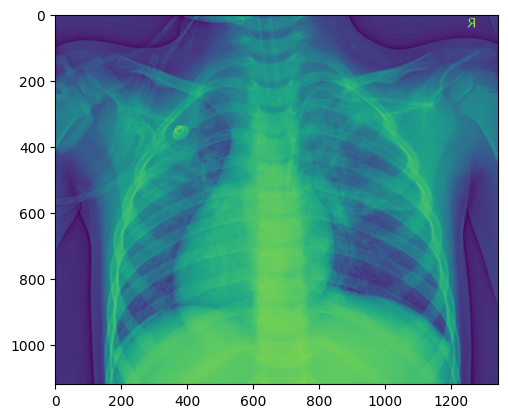

In [15]:
# Random Horizontal Flip
image = read_image(current_directory + '/test/PNEUMONIA/person3_virus_17.jpeg')
image = T.RandomHorizontalFlip(p=0.5)(image)

image = image.squeeze() # Remove the channel dimension because it's grayscale
plt.imshow(image, cmap='viridis')  
plt.show() 

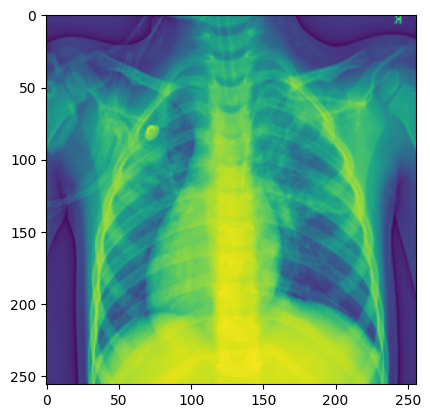

In [17]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Rescaling
image = T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33))(image)


# Remove the batch dimension for displaying
image = image.squeeze(0)  # Now image is (C, H, W) again

# Display the image
plt.imshow(image.squeeze(), cmap='viridis')  # Use .squeeze() only if it's a grayscale image
plt.show()